# Initial Preperation

we first set up the environment, import packages, and load data. Since the data are first curated, we simply need to load them.

## import packages 

In [2]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import pandas as pd
import json
import requests
import io
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib_venn as mpv
from scipy.stats import pearsonr
import numpy as np
import getpass, os
from matplotlib_venn import venn2

# set up visualization parameters
sns.set_context("paper")
sns.set_style("whitegrid")
sns.set_palette("Set2")
pal = sns.color_palette()
plt.rcParams['figure.figsize'] = [10,10]

pd.set_option('display.max_columns',(90))
pd.set_option('display.max_rows',(20))

# Import AMPL libraries
import atomsci.ddm.utils.data_curation_functions as dcf
import atomsci.ddm.utils.curate_data as curate_data
import atomsci.ddm.pipeline.diversity_plots as dp
import atomsci.ddm.pipeline.chem_diversity as cd
import atomsci.ddm.pipeline.model_pipeline as mp
import atomsci.ddm.pipeline.parameter_parser as parse
import atomsci.ddm.utils.struct_utils as struct_utils
from atomsci.ddm.pipeline import perf_plots as pp

! pip install rdkit-pypi
! pip install --pre deepchem

import deepchem
# print(deepchem.__version__)
! pip install umap
! pip install llvmlite==0.35.0  --ignore-installed
! pip install umap-learn
! pip install molvs
! pip install bravado

Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/home/jupyter/atomsci/lib/python3.8/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. jax requires jaxlib to be installed. See https://github.com/google/jax#installation for installation instructions.


  Using cached llvmlite-0.35.0.tar.gz (121 kB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [26 lines of output]
      running bdist_wheel
      /opt/conda/bin/python3.10 /var/tmp/pip-install-58q4syxv/llvmlite_f2f36385bd87423d8af472052664993a/ffi/build.py
      LLVM version... Traceback (most recent call last):
        File "/var/tmp/pip-install-58q4syxv/llvmlite_f2f36385bd87423d8af472052664993a/ffi/build.py", line 105, in main_posix
          out = subprocess.check_output([llvm_config, '--version'])
        File "/opt/conda/lib/python3.10/subprocess.py", line 421, in check_output
          return run(*popenargs, stdout=PIPE, timeout=timeout, check=True,
        File "/opt/conda/lib/python3.10/subprocess.py", line 503, in run
          with Popen(*popenargs, **kwargs) as process:
        File "/opt/conda/lib/python3.10/subprocess.py", line 971, in __init__
          sel

## load data 

In [4]:
import os
# get working directory
!pwd

/home/jupyter


In [10]:
# this dataset have curated compounds and number of functional groups
data_func = pd.read_csv('new_columbia_curated.csv', header = 0)
data_func.head()

,chembl_id,smiles,mw,GFN2_HOMO_LUMO_GAP,DFT_HOMO_LUMO_GAP,rdkit_smiles,inchi_key,compound_id,VALUE_NUM_mean,VALUE_NUM_std,Perc_Var,Remove_BadDuplicate,amides,carboxy,sulfonyl,sulfonamide,alcohol,acrylate,aldehyde,methoxyalcohol,hydroxyacetamide,acrylamide,carbamate,oxyirane,allamide,amide_NH2,HA_count
0,CHEMBL1,[H]c1c([H])c2c(c([H])c1OC([H])([H])[H])OC([H])...,544.209718,0.044924,0.242930,COc1ccc2c(c1)OC[C@H]1[C@@H]2C2=C(OC1(C)C)C1=C(...,GHBOEFUAGSHXPO-XZOTUCIWSA-N,GHBOEFUAGSHXPO-XZOTUCIWSA-N,0.242102,0.000833,0.341925,0,0,0,0,0,2,0,3,0,0,0,0,0,0,0,0
1,CHEMBL1000,[H]OC(=O)C([H])([H])OC([H])([H])C([H])([H])N1C...,388.155370,0.115170,0.340824,O=C(O)COCCN1CCN([C@@H](c2ccccc2)c2ccc(Cl)cc2)CC1,ZKLPARSLTMPFCP-NRFANRHFSA-N,ZKLPARSLTMPFCP-NRFANRHFSA-N,0.333456,0.006397,2.209649,0,0,4,0,0,2,0,3,0,0,0,0,0,0,0,0
2,CHEMBL10000,[H]c1c([H])c(N([H])c2nc3c([H])c([H])c([H])c([H...,363.970876,0.106596,0.293095,O=c1oc(Nc2ccc(I)cc2)nc2ccccc12,KXLZEFPIBPQEAU-UHFFFAOYSA-N,KXLZEFPIBPQEAU-UHFFFAOYSA-N,0.289124,0.003439,1.373521,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,CHEMBL100003,[H]O/C(OC([H])([H])[H])=C1\C(C([H])([H])[H])=N...,281.162708,0.080096,0.275410,CCC[C@@H]1C(C(=O)OCC)=C(C)N=C(C)/C1=C(\O)OC,FCFUFMMLEUYHMD-CDZMIXDFSA-N,FCFUFMMLEUYHMD-CDZMIXDFSA-N,0.282891,0.007237,2.644696,0,0,4,0,0,2,5,3,3,0,0,0,0,0,0,0
4,CHEMBL100004,[H]O/C(OC([H])([H])C([H])([H])[H])=C1\C(C([H])...,375.150429,0.069851,0.272307,CCO/C(O)=C1/C(C)=NC(C)=C(C(=O)OCCSc2ccccc2)[C@...,CUHAMGYOMBKPLA-BQOWYSNXSA-N,CUHAMGYOMBKPLA-BQOWYSNXSA-N,0.272592,0.003115,0.104604,0,0,4,0,0,2,5,3,3,0,0,0,0,0,0,0


In [9]:
# this dataset is the original one, no rdkit smiles, compound_id, not curated
raw_data = pd.read_csv('QMUGs_Data.csv', header = 0)
raw_data.head()

,chembl_id,conf_id,smiles,mw,atoms,heavy_atoms,heteroatoms,rotatable_bonds,stereocenters,rings,hbond_acceptors,hbond_donors,significant_negative_wavenumbers,nonunique_smiles,GFN2_TOTAL_ENERGY,GFN2_ATOMIC_ENERGY,GFN2_FORMATION_ENERGY,GFN2_TOTAL_ENTHALPY,GFN2_TOTAL_FREE_ENERGY,GFN2_DIPOLE_X,GFN2_DIPOLE_Y,GFN2_DIPOLE_Z,GFN2_DIPOLE_TOT,GFN2_QUADRUPOLE_XX,GFN2_QUADRUPOLE_XY,GFN2_QUADRUPOLE_YY,GFN2_QUADRUPOLE_XZ,GFN2_QUADRUPOLE_yz,GFN2_QUADRUPOLE_ZZ,GFN2_ROT_CONSTANT_A,GFN2_ROT_CONSTANT_B,GFN2_ROT_CONSTANT_C,GFN2_ENTHALPY_VIB,GFN2_ENTHALPY_ROT,GFN2_ENTHALPY_TRANSL,GFN2_ENTHALPY_TOT,GFN2_HEAT_CAPACITY_VIB,GFN2_HEAT_CAPACITY_ROT,GFN2_HEAT_CAPACITY_TRANSL,GFN2_HEAT_CAPACITY_TOT,GFN2_ENTROPY_VIB,GFN2_ENTROPY_ROT,GFN2_ENTROPY_TRANSL,GFN2_ENTROPY_TOT,GFN2_HOMO_ENERGY,GFN2_LUMO_ENERGY,GFN2_HOMO_LUMO_GAP,GFN2_FERMI_LEVEL,GFN2_DISPERSION_COEFFICIENT_MOLECULAR,GFN2_POLARIZABILITY_MOLECULAR,DFT_TOTAL_ENERGY,DFT_ATOMIC_ENERGY,DFT_FORMATION_ENERGY,DFT_DIPOLE_X,DFT_DIPOLE_Y,DFT_DIPOLE_Z,DFT_DIPOLE_TOT,DFT_ROT_CONSTANT_A,DFT_ROT_CONSTANT_B,DFT_ROT_CONSTANT_C,DFT_XC_ENERGY,DFT_NUCLEAR_REPULSION_ENERGY,DFT_ONE_ELECTRON_ENERGY,DFT_TWO_ELECTRON_ENERGY,DFT_HOMO_ENERGY,DFT_LUMO_ENERGY,DFT_HOMO_LUMO_GAP
0,CHEMBL1,conf_00,[H]c1c([H])c2c(c([H])c1OC([H])([H])[H])OC([H])...,544.209718,72,40,8,8,4,7,8,0,False,False,-117.426790,-100.117788,-17.309002,-116.820431,-116.920184,-2.618,-5.658,-3.467,7.134,7.227,3.615,11.107,3.188,-21.116,-18.335,0.004667,0.001914,0.001602,20783.593,888.752,1481.254,23153.599,136.843,2.981,4.968,144.792,127.233,37.965,44.750,209.947,-0.370232,-0.325308,0.044924,-0.347627,57856.896739,367.965458,-1838.542026,-1825.432388,-13.109638,-2.323990,-4.666405,-2.877058,5.954303,0.004576,0.001899,0.001602,-175.593881,4799.908504,-12057.970923,5595.187765,-0.285599,-0.042669,0.242930
1,CHEMBL1,conf_01,[H]c1c([H])c2c(c([H])c1OC([H])([H])[H])OC([H])...,544.209718,72,40,8,8,4,7,8,0,False,False,-117.427187,-100.117788,-17.309399,-116.820804,-116.920625,2.204,-5.729,-3.723,7.181,5.885,-5.626,9.874,-5.883,-22.364,-15.760,0.004679,0.001906,0.001589,20790.307,888.752,1481.254,23160.313,136.847,2.981,4.968,144.796,127.367,37.975,44.750,210.091,-0.370224,-0.325892,0.044332,-0.347913,57857.427330,367.967400,-1838.542622,-1825.432388,-13.110235,1.992229,-4.724344,-3.107961,5.995650,0.004586,0.001891,0.001589,-175.594360,4796.505804,-12051.167364,5591.786740,-0.285606,-0.043494,0.242112
2,CHEMBL1,conf_02,[H]c1c([H])c2c(c([H])c1OC([H])([H])[H])OC([H])...,544.209718,72,40,8,8,4,7,8,0,False,False,-117.427558,-100.117788,-17.309770,-116.821203,-116.921002,-0.010,-7.203,-4.951,8.741,27.962,0.056,-7.992,-1.259,-22.893,-19.970,0.004688,0.001923,0.001618,20789.237,888.752,1481.254,23159.243,136.846,2.981,4.968,144.795,127.350,37.946,44.750,210.046,-0.368963,-0.325670,0.043292,-0.347149,57858.231725,367.971006,-1838.542845,-1825.432388,-13.110458,-0.010970,-6.078252,-4.237400,7.409509,0.004561,0.001903,0.001619,-175.594405,4807.068772,-12072.359158,5602.415608,-0.284829,-0.043565,0.241264
3,CHEMBL1000,conf_00,[H]OC(=O)C([H])([H])OC([H])([H])C([H])([H])N1C...,388.155370,52,27,6,8,1,3,5,1,False,False,-80.315048,-68.493287,-11.821760,-79.870590,-79.950811,2.379,-3.195,4.509,6.017,5.337,-25.657,-4.502,-1.798,11.798,-0.835,0.009034,0.002935,0.002678,14005.394,888.752,1481.254,16375.401,91.382,2.981,4.968,99.331,88.721,36.373,43.746,168.840,-0.352364,-0.237194,0.115170,-0.294779,31094.695246,272.494292,-1609.322700,-1600.285930,-9.036771,2.142420,-2.785717,4.253252,5.517276,0.008840,0.002865,0.002636,-132.809395,2659.135307,-7485.087002,3349.488535,-0.296513,0.044311,0.340824
4,CHEMBL1000,conf_01,[H]OC(=O)C([H])([H])OC([H])([H])C([H])([H])N1C...,388.155370,52,27,6,8,1,3,5,1,False,False,-80.316592,-68.493287,-11.823305,-79.871110,-79.950661,1.939,3.543,0.750,4.110,18.589,1.773,-19.373,0.330,-9.931,0.783,0.009044,0.003971,0.003071,13984.290,888.752,1481.254,16354.297,91.615,2.981,4.968,99.564,87.747,35.936,43.746,167.429,-0.346825,-0.245217,0.101608,-0.296021,31124.172335,

In [61]:
match = ['DFT_HOMO_LUMO_GAP','mw','smiles']
append = ['atoms','heavy_atoms','rings','heteroatoms']

# this dataset merges all info needed, is used in later investigation
data = pd.merge(data_func, raw_data[match+append], on=match, how='inner')
data.head()

,chembl_id,smiles,mw,GFN2_HOMO_LUMO_GAP,DFT_HOMO_LUMO_GAP,rdkit_smiles,inchi_key,compound_id,VALUE_NUM_mean,VALUE_NUM_std,Perc_Var,Remove_BadDuplicate,amides,carboxy,sulfonyl,sulfonamide,alcohol,acrylate,aldehyde,methoxyalcohol,hydroxyacetamide,acrylamide,carbamate,oxyirane,allamide,amide_NH2,HA_count,atoms,heavy_atoms,rings,heteroatoms
0,CHEMBL1,[H]c1c([H])c2c(c([H])c1OC([H])([H])[H])OC([H])...,544.209718,0.044924,0.242930,COc1ccc2c(c1)OC[C@H]1[C@@H]2C2=C(OC1(C)C)C1=C(...,GHBOEFUAGSHXPO-XZOTUCIWSA-N,GHBOEFUAGSHXPO-XZOTUCIWSA-N,0.242102,0.000833,0.341925,0,0,0,0,0,2,0,3,0,0,0,0,0,0,0,0,72,40,7,8
1,CHEMBL1000,[H]OC(=O)C([H])([H])OC([H])([H])C([H])([H])N1C...,388.155370,0.115170,0.340824,O=C(O)COCCN1CCN([C@@H](c2ccccc2)c2ccc(Cl)cc2)CC1,ZKLPARSLTMPFCP-NRFANRHFSA-N,ZKLPARSLTMPFCP-NRFANRHFSA-N,0.333456,0.006397,2.209649,0,0,4,0,0,2,0,3,0,0,0,0,0,0,0,0,52,27,3,6
2,CHEMBL10000,[H]c1c([H])c(N([H])c2nc3c([H])c([H])c([H])c([H...,363.970876,0.106596,0.293095,O=c1oc(Nc2ccc(I)cc2)nc2ccccc12,KXLZEFPIBPQEAU-UHFFFAOYSA-N,KXLZEFPIBPQEAU-UHFFFAOYSA-N,0.289124,0.003439,1.373521,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28,19,3,5
3,CHEMBL100003,[H]O/C(OC([H])([H])[H])=C1\C(C([H])([H])[H])=N...,281.162708,0.080096,0.275410,CCC[C@@H]1C(C(=O)OCC)=C(C)N=C(C)/C1=C(\O)OC,FCFUFMMLEUYHMD-CDZMIXDFSA-N,FCFUFMMLEUYHMD-CDZMIXDFSA-N,0.282891,0.007237,2.644696,0,0,4,0,0,2,5,3,3,0,0,0,0,0,0,0,43,20,1,5
4,CHEMBL100004,[H]O/C(OC([H])([H])C([H])([H])[H])=C1\C(C([H])...,375.150429,0.069851,0.272307,CCO/C(O)=C1/C(C)=NC(C)=C(C(=O)OCCSc2ccccc2)[C@...,CUHAMGYOMBKPLA-BQOWYSNXSA-N,CUHAMGYOMBKPLA-BQOWYSNXSA-N,0.272592,0.003115,0.104604,0,0,4,0,0,2,5,3,3,0,0,0,0,0,0,0,51,26,2,6


In [63]:
data.to_csv('final_data.csv',index=False)

# Split through ring count, heavy atom, mw

The first step after data curation is to split the dataset into smaller ones. We generate several smaller dataset according to ring count, number of heavy atom, and mw.

In [3]:
data = pd.read_csv('final_data.csv',header = 0)

In [73]:
def find_percentile(data):
    # Calculating percentiles
    p25 = np.percentile(data, 25)
    p50 = np.percentile(data, 50)  # This is also the median
    p75 = np.percentile(data, 75)

    # Finding min and max
    min_value = np.min(data)
    max_value = np.max(data)

    return {
        "25th": p25,
        "Median (50th)": p50,
        "75th": p75,
        "Minimum": min_value,
        "Maximum": max_value
    }

In [26]:
# rings
print(f'rings: {find_percentile(data["rings"])}')

# heavy atoms
print(f'heavy atoms: {find_percentile(data["heavy_atoms"])}')

# heteroatoms
print(f'heteroatoms: {find_percentile(data["heteroatoms"])}')

# mw
print(f'molecular weight: {find_percentile(data["mw"])}')

rings: {'25th': 3.0, 'Median (50th)': 4.0, '75th': 5.0, 'Minimum': 0, 'Maximum': 21}
heavy atoms: {'25th': 24.0, 'Median (50th)': 29.0, '75th': 34.0, 'Minimum': 3, 'Maximum': 100}
heteroatoms: {'25th': 6.0, 'Median (50th)': 7.0, '75th': 9.0, 'Minimum': 0, 'Maximum': 60}
molecular weight: {'25th': 344.9398138655002, 'Median (50th)': 412.247440884001, '75th': 485.1925661630007, 'Minimum': 43.005813652, 'Maximum': 1645.8626918920004}


In [3]:
# split dataset based on percentile of given variable
def split(df,column):
    '''
    lower quantile: less than 25th
    mid quantile: 25th - 50th
    upper quantile: 50th - 75th
    top quantile: more than 75th
    '''
    # compute percentile
    p25 = column.quantile(0.25)
    p50 = column.quantile(0.50)
    p75 = column.quantile(0.75)

    # Splitting the dataset based on percentile ranges
    lower = df[column <= p25]
    mid = df[(column > p25) & (column <= p50)]
    upper = df[(column > p50) & (column <= p75)]
    top = df[column > p75]

    return lower,mid,upper,top

In [4]:
# rings
ring_lower,ring_mid,ring_upper,ring_top = split(data, data['rings'])

# heavy atoms
heavy_atoms_lower,heavy_atoms_mid,heavy_atoms_upper,heavy_atoms_top = split(data, data['heavy_atoms'])

# heteroatoms
heteroatoms_lower,heteroatoms_mid,heteroatoms_upper,heteroatoms_top = split(data, data['heteroatoms'])

# mw
mw_lower,mw_mid,mw_upper,mw_top = split(data, data['mw'])

In [10]:
ring_lower['rings'].describe()

count    188870.000000
mean          2.551040
std           0.675588
min           0.000000
25%           2.000000
50%           3.000000
75%           3.000000
max           3.000000
Name: rings, dtype: float64

In [93]:
heavy_atoms_lower['heavy_atoms'].describe()

count    112648.000000
mean         20.404126
std           3.225806
min           3.000000
25%          19.000000
50%          21.000000
75%          23.000000
max          24.000000
Name: heavy_atoms, dtype: float64

In [91]:
heteroatoms_lower['heteroatoms'].describe()

count    163343.000000
mean          4.786896
std           1.208106
min           0.000000
25%           4.000000
50%           5.000000
75%           6.000000
max           6.000000
Name: heteroatoms, dtype: float64

In [29]:
mw_lower['mw'].describe()

count    109429.000000
mean        288.387786
std          44.772811
min          43.005814
25%         263.105862
50%         299.046154
75%         324.097329
max         344.939435
Name: mw, dtype: float64

# Visualizations

After splitting the dataset, we want to explore further on how dft gap value might shift or change according to percentiles.

## pre plots

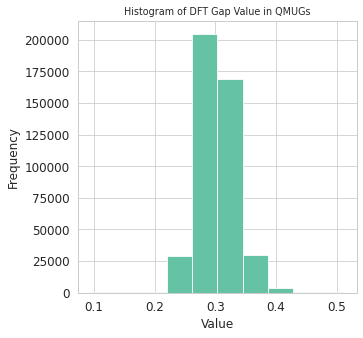

In [11]:
data['DFT_HOMO_LUMO_GAP'].hist(figsize=(5,5))
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title(f'Histogram of DFT Gap Value in QMUGs')
plt.show()

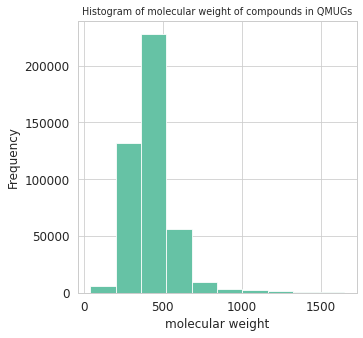

In [228]:
data['mw'].hist(figsize=(5,5))
plt.xlabel('molecular weight')
plt.ylabel('Frequency')
plt.title(f'Histogram of molecular weight of compounds in QMUGs')
plt.show()

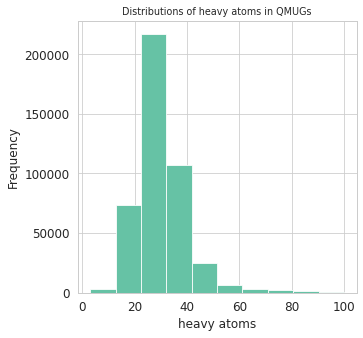

In [11]:
data['heavy_atoms'].hist(figsize=(5,5))
plt.xlabel('heavy atoms')
plt.ylabel('Frequency')
plt.title(f'Distributions of heavy atoms in QMUGs')
plt.show()

Functional group: 1 carboxy


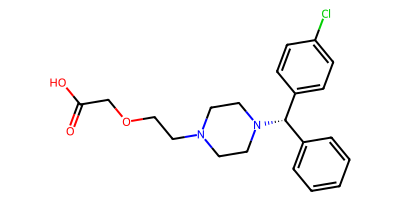

In [22]:
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors, rdqueries
from rdkit.Chem import rdchem

# show the number of functional group in the compound
m = Chem.MolFromSmiles('O=C(O)COCCN1CCN([C@@H](c2ccccc2)c2ccc(Cl)cc2)CC1')
fcarbox = Chem.MolFromSmarts('CC(O)=O')
print('Functional group:', len(m.GetSubstructMatches(fcarbox)), 'carboxy')

Draw.MolToImage(m, size=(400,200))

## functions used for plots 

In [41]:
# compare DFT gap values across subsets using histogram
def hist_compare(dataframes, column, legend, bins=20, figsize=(5,5), alpha=0.5):
    plt.figure(figsize=figsize)
    for df, label in zip(dataframes, legend):
        plt.hist(df[column], bins=bins, alpha=alpha, label=label)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of DFT Gap Value')
    plt.legend()
    plt.show()

pname=['lower quantile','middle quantile','upper quantile','top quantile']

In [38]:
# compare DFT gap values across subsets using histogram using boxplot
def box_compare(dataframes, column, legend, figsize=(10, 5)):

    # Combine all dataframes into a single dataframe with an identifying label
    combined_df = pd.concat(
        [df.assign(Dataset=label) for df, label in zip(dataframes, legend)],
        ignore_index=True
    )

    plt.figure(figsize=figsize)
    sns.boxplot(x='Dataset', y=column, data=combined_df)
    plt.title(f'Boxplot of DFT Gap Value')
    plt.show()

In [39]:
def corr(dataframes, labels, gap_col):
    for df, label in zip(dataframes, labels):
        # Selecting numeric columns only
        numeric_df = df.select_dtypes(include='number')

        # Calculating correlation matrix
        corr_matrix = numeric_df.corr()

        # Plotting the heatmap
        plt.figure(figsize=(8, 6))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
        plt.title(f'Correlation Matrix for {label}')
        plt.show()

In [ ]:
corr(ring_df, pname, 'DFT_HOMO_LUMO_GAP')

## rings 

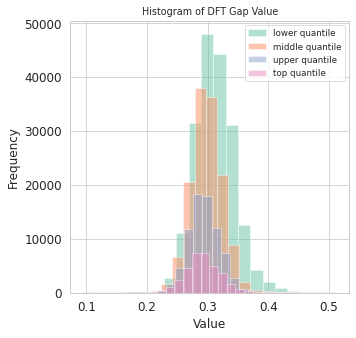

In [187]:
ring_df=[ring_lower,ring_mid,ring_upper,ring_top]
hist_compare(ring_df, 'DFT_HOMO_LUMO_GAP', legend=pname)

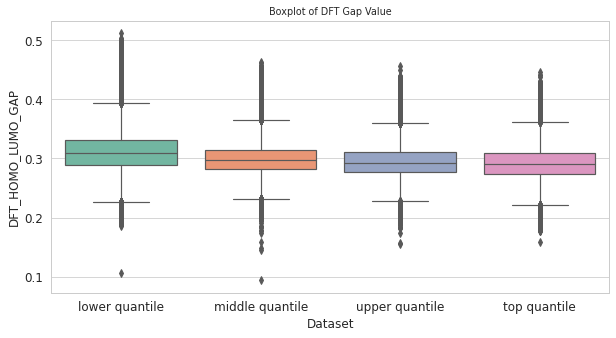

In [188]:
box_compare(ring_df, 'DFT_HOMO_LUMO_GAP', legend=pname)

In [210]:
# Analysis of Variance

from scipy import stats

# Null Hypothesis (H0): The means of the DFT gap values are the same across all ring categories.
# Alternative Hypothesis (Ha): At least one ring_df has a mean DFT gap value that is significantly different from the others.

# First, separate the DFT gap values into groups based on the 'rings' categories
groups = [df['DFT_HOMO_LUMO_GAP'].values for df in ring_df]

# Perform one-way ANOVA
f_value, p_value = stats.f_oneway(*groups)

# Print the results
print("F-value:", f_value) # ratio of the variance between the groups, F-value is large, a strong differentiation
print("P-value:", p_value) # reject null

F-value: 10437.219614876121
P-value: 0.0


In [209]:
# post hoc test

from scipy import stats
import itertools

# Assuming ring_df is a list of DataFrames or groups
groups = [df['DFT_HOMO_LUMO_GAP'].values for df in ring_df]

# Generate all pairwise combinations
pairwise_combinations = list(itertools.combinations(range(len(groups)), 2))

# Conduct pairwise t-tests and apply Bonferroni correction
p_values = []
for combo in pairwise_combinations:
    stat, p = stats.ttest_ind(groups[combo[0]], groups[combo[1]])
    p_values.append(p)

# Apply Bonferroni Correction
bonferroni_correction = len(pairwise_combinations)
adjusted_p_values = [p * bonferroni_correction for p in p_values]

# Print results
for (i, j), p in zip(pairwise_combinations, adjusted_p_values):
    print(f"Comparison between group {i} and group {j}: Adjusted P-value = {p}")

Comparison between group 0 and group 1: Adjusted P-value = 0.0
Comparison between group 0 and group 2: Adjusted P-value = 0.0
Comparison between group 0 and group 3: Adjusted P-value = 0.0
Comparison between group 1 and group 2: Adjusted P-value = 5.479313847736562e-268
Comparison between group 1 and group 3: Adjusted P-value = 0.0
Comparison between group 2 and group 3: Adjusted P-value = 1.7779472165788155e-36


## heavy atoms 

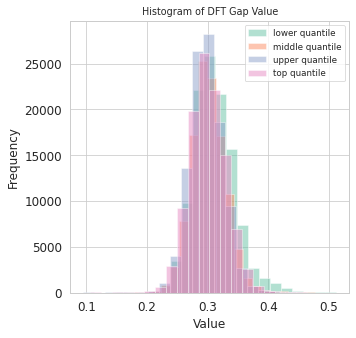

In [189]:
heavy_atoms_df=[heavy_atoms_lower,heavy_atoms_mid,heavy_atoms_upper,heavy_atoms_top]
hist_compare(heavy_atoms_df, 'DFT_HOMO_LUMO_GAP', legend=pname)

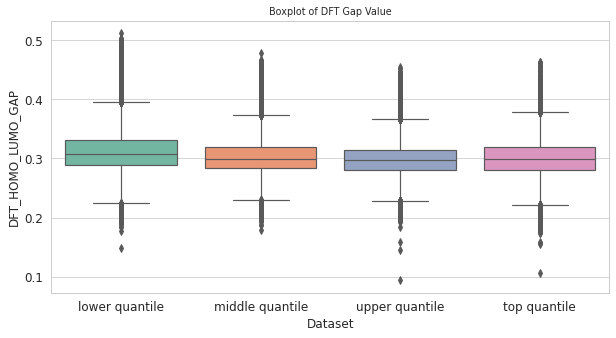

In [190]:
box_compare(heavy_atoms_df, 'DFT_HOMO_LUMO_GAP', legend=pname)

## heteroatoms 

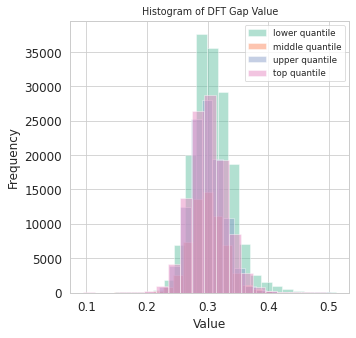

In [191]:
heteroatoms_df=[heteroatoms_lower,heteroatoms_mid,heteroatoms_upper,heteroatoms_top]
hist_compare(heteroatoms_df, 'DFT_HOMO_LUMO_GAP', legend=pname)

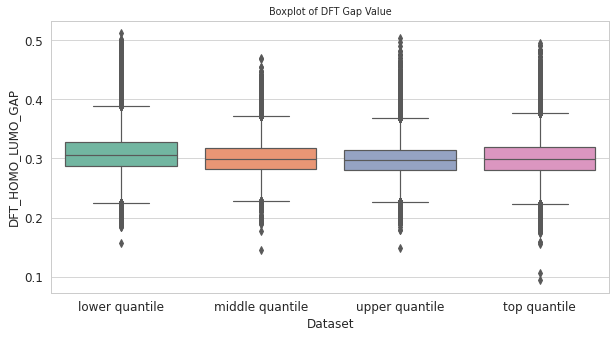

In [192]:
box_compare(heteroatoms_df, 'DFT_HOMO_LUMO_GAP', legend=pname)

## mw

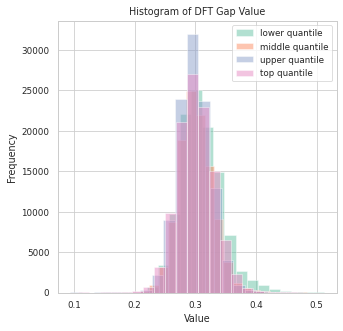

In [42]:
mw_df=[mw_lower,mw_mid,mw_upper,mw_top]
hist_compare(mw_df, 'DFT_HOMO_LUMO_GAP', legend=pname)

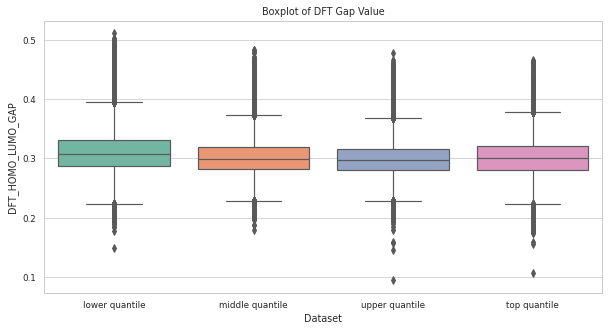

In [43]:
box_compare(mw_df, 'DFT_HOMO_LUMO_GAP', legend=pname)

# Model 

We want to see if our model is better at predicting a certain type over another.

## overivew of functional groups that we should pay attention to

we would be interested into functional groups that appears over 1000 times in the dataset.

In [12]:
fglist = ["amides","carboxy","sulfonyl", "sulfonamide", "alcohol","acrylate","aldehyde","methoxyalcohol","hydroxyacetamide","acrylamide","carbamate","oxyirane","allamide","amide_NH2"]

for i in fglist:
    print(data[i].value_counts())
    print("---------------------------")

0    302437
4    135277
Name: amides, dtype: int64
---------------------------
0    383890
4     53824
Name: carboxy, dtype: int64
---------------------------
0    434683
5      3031
Name: sulfonyl, dtype: int64
---------------------------
0    427723
5      9991
Name: sulfonamide, dtype: int64
---------------------------
2    255557
0    182157
Name: alcohol, dtype: int64
---------------------------
0    430954
5      6760
Name: acrylate, dtype: int64
---------------------------
0    250570
3    187144
Name: aldehyde, dtype: int64
---------------------------
0    427857
3      9857
Name: methoxyalcohol, dtype: int64
---------------------------
0    429508
4      8206
Name: hydroxyacetamide, dtype: int64
---------------------------
0    422923
5     14791
Name: acrylamide, dtype: int64
---------------------------
0    420982
4     16732
Name: carbamate, dtype: int64
---------------------------
0    437195
3       519
Name: oxyirane, dtype: int64
---------------------------
3    239469


## function to implement model and find r^2 

In [5]:
from atomsci.ddm.pipeline import predict_from_model as pfm

In [6]:
ring_lower

,chembl_id,smiles,mw,GFN2_HOMO_LUMO_GAP,DFT_HOMO_LUMO_GAP,rdkit_smiles,inchi_key,compound_id,VALUE_NUM_mean,VALUE_NUM_std,Perc_Var,Remove_BadDuplicate,amides,carboxy,sulfonyl,sulfonamide,alcohol,acrylate,aldehyde,methoxyalcohol,hydroxyacetamide,acrylamide,carbamate,oxyirane,allamide,amide_NH2,HA_count,atoms,heavy_atoms,rings,heteroatoms
1,CHEMBL1000,[H]OC(=O)C([H])([H])OC([H])([H])C([H])([H])N1C...,388.155370,0.115170,0.340824,O=C(O)COCCN1CCN([C@@H](c2ccccc2)c2ccc(Cl)cc2)CC1,ZKLPARSLTMPFCP-NRFANRHFSA-N,ZKLPARSLTMPFCP-NRFANRHFSA-N,0.333456,0.006397,2.209649,0,0,4,0,0,2,0,3,0,0,0,0,0,0,0,0,52,27,3,6
2,CHEMBL10000,[H]c1c([H])c(N([H])c2nc3c([H])c([H])c([H])c([H...,363.970876,0.106596,0.293095,O=c1oc(Nc2ccc(I)cc2)nc2ccccc12,KXLZEFPIBPQEAU-UHFFFAOYSA-N,KXLZEFPIBPQEAU-UHFFFAOYSA-N,0.289124,0.003439,1.373521,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28,19,3,5
3,CHEMBL100003,[H]O/C(OC([H])([H])[H])=C1\C(C([H])([H])[H])=N...,281.162708,0.080096,0.275410,CCC[C@@H]1C(C(=O)OCC)=C(C)N=C(C)/C1=C(\O)OC,FCFUFMMLEUYHMD-CDZMIXDFSA-N,FCFUFMMLEUYHMD-CDZMIXDFSA-N,0.282891,0.007237,2.644696,0,0,4,0,0,2,5,3,3,0,0,0,0,0,0,0,43,20,1,5
4,CHEMBL100004,[H]O/C(OC([H])([H])C([H])([H])[H])=C1\C(C([H])...,375.150429,0.069851,0.272307,CCO/C(O)=C1/C(C)=NC(C)=C(C(=O)OCCSc2ccccc2)[C@...,CUHAMGYOMBKPLA-BQOWYSNXSA-N,CUHAMGYOMBKPLA-BQOWYSNXSA-N,0.272592,0.003115,0.104604,0,0,4,0,0,2,5,3,3,0,0,0,0,0,0,0,51,26,2,6
6,CHEMBL100010,[H]c1c([H])c([H])c(C2=C(C(=O)OC([H])([H])[H])[...,242.130680,0.124809,0.336471,COC(=O)C1=C(c2ccccc2)C[C@@H]2CC[C@H]1C2,BXNXEXWOZMNHST-YPMHNXCESA-N,BXNXEXWOZMNHST-YPMHNXCESA-N,0.337342,0.002364,0.258233,0,0,4,0,0,2,5,3,0,0,0,0,0,0,0,0,36,18,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437701,CHEMBL387607,[H]c1c([H])c(C([H])([H])[H])c([H])c(S(=O)(=O)N...,328.124549,0.099953,0.303607,Cc1cccc(S(=O)(=O)N[C@@H](C)Cc2c[nH]c3ccccc23)c1,VSEVKTHQRFCTGZ-AWEZNQCLSA-N,VSEVKTHQRFCTGZ-AWEZNQCLSA-N,0.312456,0.008363,2.832099,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,43,23,3,5
437707,CHEMBL387619,[H]C(=O)C([H])([H])Oc1c([H])c([H])c([H])c([H])...,266.055464,0.120873,0.334670,O=CCOc1ccccc1-c1ccc(F)c(F)c1F,SHBOZVYTDQJORM-UHFFFAOYSA-N,SHBOZVYTDQJORM-UHFFFAOYSA-N,0.335084,0.004400,0.123614,0,0,0,0,0,2,0,3,0,0,0,0,0,0,0,0,28,19,2,5
437709,CHEMBL387620,[H]OC1(C([H])([H])N([H])C(=O)c2c([H])nc(N([H])...,428.122688,0.093705,0.294959,O=C(NCC1(O)CCCCC1)c1cnc(Nc2cccc(Cl)c2)nc1C(F)(F)F,FIPRYNJHSXMAOS-UHFFFAOYSA-N,FIPRYNJHSXMAOS-UHFFFAOYSA-N,0.295589,0.000838,0.213117,0,0,0,0,0,2,0,0,0,0,0,0,0,3,0,0,49,29,3,10
437710,CHEMBL387624,[H]/C(=C1/SC(=S)N([H])C1=O)c1c([H])c([H])c(F)c...,238.987484,0.049469,0.262288,O=C1NC(=S)S/C1=C\c1ccc(F)cc1,BQOQSIQMDZUHKF-YVMONPNESA-N,BQOQSIQMDZUHKF-YVMONPNESA-N,0.262236,0.000048,0.019827,0,4,0,0,0,0,0,3,0,0,5,0,0,3,0,0,21,15,2,5


In [7]:
def fit(mfile, input_df, smiles_col, response_col):
    results_df = pfm.predict_from_model_file(model_path=mfile,
                                             input_df=input_df, 
                                             smiles_col=smiles_col, 
                                             response_col=response_col)
    return results_df

def find_r2(df, actual_col, predicted_col):
    actual = df[actual_col].values
    predicted = df[predicted_col].values

    # Calculate the correlation matrix and then R-squared
    corr_matrix = np.corrcoef(actual, predicted)
    r2 = corr_matrix[0, 1] ** 2

    return r2

In [8]:
mfile = '/home/jupyter/Models/select_qmugs_data_curated (2)_model_d45eab0f-3f53-4036-a3e5-0a0217a52e23.tar.gz'

results_df = fit(mfile, ring_lower, 'rdkit_smiles', 'DFT_HOMO_LUMO_GAP')
r_squared = find_r2(results_df, 'DFT_HOMO_LUMO_GAP', 'DFT_HOMO_LUMO_GAP_pred')
print(f"R-squared Value for rand split with graphconv: {r_squared}")

Standardizing SMILES strings for 188870 compounds.


2024-01-24 17:13:54,913 /home/jupyter/Models/select_qmugs_data_curated (2)_model_d45eab0f-3f53-4036-a3e5-0a0217a52e23.tar.gz, 1.5.1
2024-01-24 17:13:54,917 Version compatible check: /home/jupyter/Models/select_qmugs_data_curated (2)_model_d45eab0f-3f53-4036-a3e5-0a0217a52e23.tar.gz version = "1.5", AMPL version = "1.5"
2024-01-24 17:13:55,448 ['ampl_version', 'time_generated', 'best_epoch', 'time_built', 'dataset_hash', 'dataset_metadata', 'training_metrics'] are not part of the accepted list of parameters and will be ignored
2024-01-24 17:13:55,486 Featurization = DynamicFeaturization with graphconv features


num_model_tasks is deprecated and its value is ignored.


KeyError: "['DFT_HOMO_LUMO_GAP'] not in index"

In [ ]:
## random graphconv
mfile = '/home/jupyter/Models/select_qmugs_data_curated (2)_model_d45eab0f-3f53-4036-a3e5-0a0217a52e23.tar.gz'
mpath = '/content'
input_df = test_amide
response_col = "DFT_HOMO_LUMO_GAP,DFT_HOMO_LUMO_GAP"
compound_id = 'compound_id'
smiles_col = "rdkit_smiles"
results_df = pfm.predict_from_model_file(model_path = mfile, 
                            input_df = input_df, 
                            smiles_col = smiles_col, 
                            response_col = response_col)

In [ ]:
## random graphconv DFT R2

dft_amide_actual = results_df['DFT_HOMO_LUMO_GAP'].values
dft_amide_predict = results_df['DFT_HOMO_LUMO_GAP_pred'].values

corr_matrix_amide_R_sq_randsplit = numpy.corrcoef(dft_amide_actual, dft_amide_predict)
corr_amide_R_sq_randsplit = corr_matrix_amide_R_sq_randsplit[0,1]
dft_amide_R_sq_randsplit = corr_amide_R_sq_randsplit**2

print(dft_amide_R_sq_randsplit)

the first 3 models used graphconv and the next 3 used ecfp.  The R2 I sent you last night is the R2 for the model training themselves.

I would try to compare the data to the overall R2.  This will show if the model is generalizable and can predict a diverse set of compounds, or if it is just focused on for example a low M/W or heavy M/W; or if it is good at predicting amines but not sulfonyls.

And you are looking at the test R2 I just included the train just because a lot of times that is how it is reported

## model fitting based on ring count 

## model fitting based on functional group 

In [12]:
test_amide = pd.read_csv('amide_df.csv')
test_amide.head()

,chembl_id,compound_id,rdkit_smiles,GFN2_HOMO_LUMO_GAP,DFT_HOMO_LUMO_GAP,amides,HA_count
0,CHEMBL100013,CKPLPYKNMZXMFH-NDEPHWFRSA-N,Nc1nccc2ccc(C(=O)N3Cc4ccccc4C[C@H]3C(=O)Nc3ccc...,0.090916,0.283768,4,0
1,CHEMBL100017,ZQYURDSEXOLQFN-SFTDATJTSA-N,CC(C)N1CC(=O)[C@@H](NC(=O)[C@H](Cc2ccccc2)NC(=...,0.098687,0.345032,4,0
2,CHEMBL100029,GFRHLCDSWKISNK-UHFFFAOYSA-N,O=C(Cc1c(-c2ccccc2)[nH]c2ccccc12)N1CCCCC1,0.108617,0.297044,4,0
3,CHEMBL100033,MRISQXIQFOEPLQ-MCHVOXOFSA-N,CO[C@@H](Cc1ccccc1)[C@@H](C)/C=C(C)/C=C/[C@H](...,0.121755,0.325069,4,0
4,CHEMBL100034,CVKKUZMEEKVVIR-YTCPBCGMSA-N,CCCCNC(=O)N(CC(C)C)C[C@@H](O)[C@H](Cc1ccccc1)N...,0.074936,0.281398,4,3


In [13]:
## Random split, graphconv, NN
mfile = '/home/jupyter/Models/select_qmugs_data_curated (2)_model_d45eab0f-3f53-4036-a3e5-0a0217a52e23.tar.gz'
mpath = '/content'
input_df = test_amide
response_col = "DFT_HOMO_LUMO_GAP,DFT_HOMO_LUMO_GAP"
compound_id = 'compound_id'
smiles_col = "rdkit_smiles"
results_df = pfm.predict_from_model_file(model_path = mfile, 
                            input_df = input_df, 
                            smiles_col = smiles_col, 
                            response_col = response_col)

Standardizing SMILES strings for 135277 compounds.


INFO:atomsci.ddm.utils.model_version_utils:/home/jupyter/Models/select_qmugs_data_curated (2)_model_d45eab0f-3f53-4036-a3e5-0a0217a52e23.tar.gz, 1.5.1
INFO:atomsci.ddm.utils.model_version_utils:Version compatible check: /home/jupyter/Models/select_qmugs_data_curated (2)_model_d45eab0f-3f53-4036-a3e5-0a0217a52e23.tar.gz version = "1.5", AMPL version = "1.5"
INFO:ATOM:Featurization = DynamicFeaturization with graphconv features


num_model_tasks is deprecated and its value is ignored.


In [15]:
## random split DFT R2

dft_amide_actual = results_df['DFT_HOMO_LUMO_GAP'].values
dft_amide_predict = results_df['DFT_HOMO_LUMO_GAP_pred'].values

corr_matrix_amide_R_sq_randsplit = np.corrcoef(dft_amide_actual, dft_amide_predict)
corr_amide_R_sq_randsplit = corr_matrix_amide_R_sq_randsplit[0,1]
dft_amide_R_sq_randsplit = corr_amide_R_sq_randsplit**2

print(dft_amide_R_sq_randsplit)

0.9400319136196058


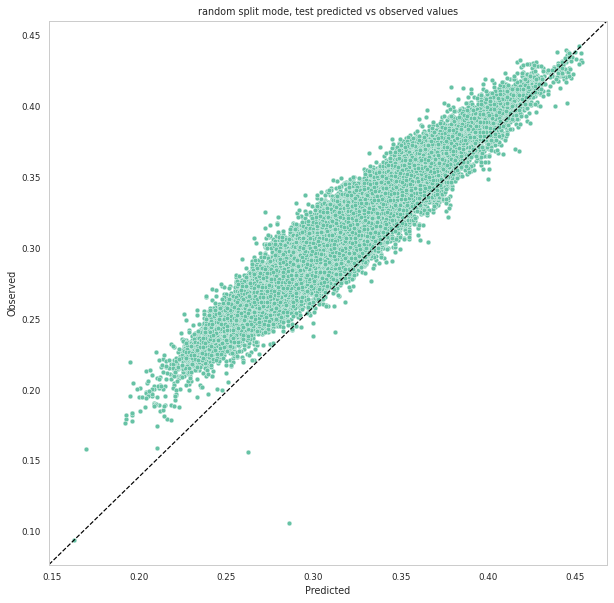

In [36]:
# plot to see how pred deviate from observed
sns.scatterplot(data=results_df, x='DFT_HOMO_LUMO_GAP_pred', y='DFT_HOMO_LUMO_GAP')

# Plot a line for perfect prediction
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, ls="--", c="black")

plt.title('random split mode, test predicted vs observed values')
plt.xlabel('Predicted')
plt.ylabel('Observed')

plt.grid(False)

# Show the plot
plt.show()